In [1]:
import pandas as pd
import numpy as np
import cython
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from CalculateMetrics import calculate_all_metrics

df = pd.read_csv("C:/Users/iwama/Desktop/Osobiste/MSc/put-msc/Endometriosis/endometriosis.csv")
X = df.drop(columns=['target'])
y = df['target'].astype('int')
# # Split the data into training and testing sets
# X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.4, random_state=42, stratify=y_test_val)

# holdout + CV
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
print(f"Train/Val size: {len(y_trainval)}, Test size: {len(y_test)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Train/Val size: 742, Test size: 132
Class distribution in test set: [109  23]


In [2]:
# XGBoost
import xgboost as xgb
param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [4, 5, 6]  # based on imbalance ratio
}
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-val F1:", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'scale_pos_weight': 4, 'subsample': 0.6}
Best cross-val F1: 0.5238425856372035

Test set evaluation:
              precision    recall  f1-score   support

           0     0.9143    0.8807    0.8972       109
           1     0.5185    0.6087    0.5600        23

    accuracy                         0.8333       132
   macro avg     0.7164    0.7447    0.7286       132
weighted avg     0.8453    0.8333    0.8384       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             96                  13                    # True Negative (TN), False Positive (FP)
Class 1             9                   14                    # False Negative (FN), True Positive (TP)


In [ ]:
from EnderClassifierModified import EnderClassifier as ECM

param_grid = {
    'n_rules': [i for i in range(1, 40)],
    'use_gradient': [True, False],
    'nu': [0.9, 0.95, 0.99, 1.0],
    'sampling': [0.4, 0.6, 0.8, 0.9, 1.0],
    'verbose': [False]
}

grid_search_m = GridSearchCV(
    estimator=ECM(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_m.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_m.best_params_)
print("Best cross-val F1:", grid_search_m.best_score_)

best_model = grid_search_m.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'n_rules': 34, 'nu': 0.9, 'sampling': 0.4, 'use_gradient': False, 'verbose': False}
Best cross-val F1: 0.4390635684425014

Test set evaluation:
              precision    recall  f1-score   support

           0     0.8571    0.9358    0.8947       109
           1     0.4615    0.2609    0.3333        23

    accuracy                         0.8182       132
   macro avg     0.6593    0.5983    0.6140       132
weighted avg     0.7882    0.8182    0.7969       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             102                 7                     # True Negative (TN), False Positive (FP)
Class 1             17                  6                     # False Negative (FN), True Positive (TP)


In [ ]:
# get the indexes of the top 20 highest values from the mean_test_score
top_20_indices = sorted(range(len(grid_search_m.cv_results_['mean_test_score'])), key=lambda i: grid_search_m.cv_results_['mean_test_score'][i], reverse=True)[:20]
print(top_20_indices)
# Get the parameters for the top 20
top_20_params = [grid_search_m.cv_results_['params'][i] for i in top_20_indices]
print(top_20_params)
print("=====================================================")
# print the scores alongside the parameters for the top 20
for i in top_20_indices:
    print(f"Score: {grid_search_m.cv_results_['mean_test_score'][i]}, Params: {grid_search_m.cv_results_['params'][i]}")
    print("=====================================================")

# save the top 20 parameters into a file in json format
import json
with open('top_20_params_ecbf_2608.json', 'w') as f:
    json.dump(top_20_params, f, indent=4)
# save the scores in a file as well
with open('top_20_scores_ecbf_2608.json', 'w') as f:
    json.dump([grid_search_m.cv_results_['mean_test_score'][i] for i in top_20_indices], f, indent=4)

In [ ]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF

param_grid = {
    'n_rules': [i for i in range(24, 41)],
    'use_gradient': [True, False],
    'nu': [0.9, 0.95, 0.99, 1.0],
    'sampling': [0.4, 0.6, 0.8, 0.9, 1.0],
    'verbose': [False],
    'max_clusters': [i for i in range(1, 6)],
    'lambda_reg': [0.0, 0.1, 0.24, 0.5, 0.75, 1.0]
}

grid_search_bf = GridSearchCV(
    estimator=ECBF(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_bf.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_bf.best_params_)
print("Best cross-val F1:", grid_search_bf.best_score_)

best_model = grid_search_bf.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'lambda_reg': 1.0, 'max_clusters': 1, 'n_rules': 39, 'nu': 0.9, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}
Best cross-val F1: 0.4829869278778136

Test set evaluation:
              precision    recall  f1-score   support

           0     0.8860    0.9266    0.9058       109
           1     0.5556    0.4348    0.4878        23

    accuracy                         0.8409       132
   macro avg     0.7208    0.6807    0.6968       132
weighted avg     0.8284    0.8409    0.8330       132

Confusion Matrix:
                    Class 0             Class 1             
Class 0             101                 8                     # True Negative (TN), False Positive (FP)
Class 1             13                  10                    # False Negative (FN), True Positive (TP)


In [ ]:
# get the indexes of the top 20 highest values from the mean_test_score
top_20_indices = sorted(range(len(grid_search_bf.cv_results_['mean_test_score'])), key=lambda i: grid_search_bf.cv_results_['mean_test_score'][i], reverse=True)[:20]
print(top_20_indices)
# Get the parameters for the top 20
top_20_params = [grid_search_bf.cv_results_['params'][i] for i in top_20_indices]
print(top_20_params)
print("=====================================================")
# print the scores alongside the parameters for the top 20
for i in top_20_indices:
    print(f"Score: {grid_search_bf.cv_results_['mean_test_score'][i]}, Params: {grid_search_bf.cv_results_['params'][i]}")
    print("=====================================================")

# save the top 20 parameters into a file in json format
import json
with open('top_20_params_ecbf_2608.json', 'w') as f:
    json.dump(top_20_params, f, indent=4)
# save the scores in a file as well
with open('top_20_scores_ecbf_2608.json', 'w') as f:
    json.dump([grid_search_bf.cv_results_['mean_test_score'][i] for i in top_20_indices], f, indent=4)

[85171, 55681, 12424, 65517, 12675, 67949, 25860, 12679, 52245, 64421, 42157, 35611, 42332, 58793, 12345, 84667, 62241, 58291, 47116, 35773]
[{'lambda_reg': 1.0, 'max_clusters': 1, 'n_rules': 39, 'nu': 0.9, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.2, 'max_clusters': 2, 'n_rules': 39, 'nu': 0.9, 'sampling': 0.4, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.0, 'max_clusters': 4, 'n_rules': 31, 'nu': 0.9, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}, {'lambda_reg': 0.2, 'max_clusters': 5, 'n_rules': 39, 'nu': 0.9, 'sampling': 0.9, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.0, 'max_clusters': 4, 'n_rules': 34, 'nu': 0.9, 'sampling': 0.5, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.5, 'max_clusters': 1, 'n_rules': 29, 'nu': 0.9, 'sampling': 0.6, 'use_gradient': False, 'verbose': False}, {'lambda_reg': 0.01, 'max_clusters': 3, 'n_rules': 35, 'nu': 0.9, 'sampling': 0.4, 'use_gradient': True, 'verbose':

In [3]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF
import json

def run_small_test(model, name, X_trainval, y_trainval, X_test, y_test, verbose=True):
    model.fit(X_trainval, y_trainval)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    if verbose:
        print("================================")
        print(f"{name} - Accuracy: {acc:.4f}, ROC AUC: {roc:.4f}, F1 Score: {f1:.4f}")

    return acc, roc, f1

# read the parameters from the json file
with open('top_20_params_ecbf_2508.json', 'r') as f:
    parameters = json.load(f)

for params in parameters:
    test_model = ECBF(**params)
    run_small_test(test_model, "Test model", X_trainval, y_trainval, X_test, y_test, verbose=True)
    print("================================\n")

Test model - Accuracy: 0.8788, ROC AUC: 0.8353, F1 Score: 0.5556

Test model - Accuracy: 0.8333, ROC AUC: 0.8045, F1 Score: 0.3889

Test model - Accuracy: 0.8333, ROC AUC: 0.7994, F1 Score: 0.4211

Test model - Accuracy: 0.8409, ROC AUC: 0.8751, F1 Score: 0.4615

Test model - Accuracy: 0.8106, ROC AUC: 0.8133, F1 Score: 0.3902

Test model - Accuracy: 0.8561, ROC AUC: 0.8759, F1 Score: 0.4242

Test model - Accuracy: 0.8561, ROC AUC: 0.8297, F1 Score: 0.4571

Test model - Accuracy: 0.8561, ROC AUC: 0.8452, F1 Score: 0.4571

Test model - Accuracy: 0.8409, ROC AUC: 0.8444, F1 Score: 0.4000

Test model - Accuracy: 0.8561, ROC AUC: 0.8600, F1 Score: 0.4571

Test model - Accuracy: 0.8182, ROC AUC: 0.8081, F1 Score: 0.2941

Test model - Accuracy: 0.8712, ROC AUC: 0.8448, F1 Score: 0.5143

Test model - Accuracy: 0.8258, ROC AUC: 0.8237, F1 Score: 0.3429

Test model - Accuracy: 0.8561, ROC AUC: 0.8871, F1 Score: 0.4242

Test model - Accuracy: 0.8561, ROC AUC: 0.8736, F1 Score: 0.4865

Test model

In [2]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_val.value_counts())

target
0    504
1    107
Name: count, dtype: int64
target
0    130
1     27
Name: count, dtype: int64
target
0    87
1    19
Name: count, dtype: int64


In [19]:
def run_test(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(name)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("Classification Report - Test:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    labels = ['Class 0', 'Class 1']
    print("Confusion Matrix:")
    print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
    print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
    print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

def run_small_test(model, name, X_train, y_train, X_test, y_test, verbose=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    if verbose:
        print("================================")
        print(f"{name} - Accuracy: {acc:.4f}, ROC AUC: {roc:.4f}, F1 Score: {f1:.4f}")

    return acc, roc, f1

XGBoost Classifier
Accuracy: 0.8217
ROC AUC: 0.7877
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       130
           1       0.47      0.26      0.33        27

    accuracy                           0.82       157
   macro avg       0.66      0.60      0.62       157
weighted avg       0.79      0.82      0.80       157

Confusion Matrix:
                    Class 0             Class 1             
Class 0             122                 8                     # True Negative (TN), False Positive (FP)
Class 1             20                  7                     # False Negative (FN), True Positive (TP)


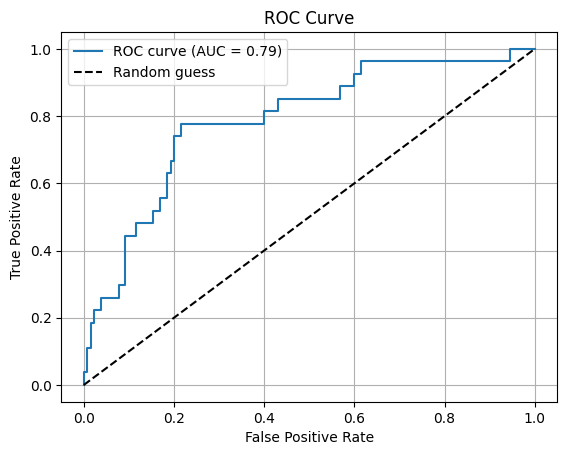

In [4]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
run_test(xgb_model, "XGBoost Classifier", X_train, y_train, X_test, y_test)

Ender Classifier Modified
Accuracy: 0.8471
ROC AUC: 0.8132
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       130
           1       0.58      0.41      0.48        27

    accuracy                           0.85       157
   macro avg       0.73      0.67      0.69       157
weighted avg       0.83      0.85      0.84       157

Confusion Matrix:
                    Class 0             Class 1             
Class 0             122                 8                     # True Negative (TN), False Positive (FP)
Class 1             16                  11                    # False Negative (FN), True Positive (TP)


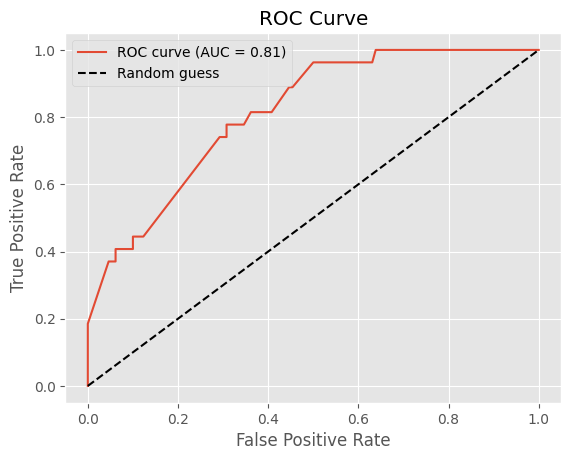

In [5]:
from EnderClassifierModified import EnderClassifier as ECM

ecm = ECM(verbose=False, n_rules=10, use_gradient=False)
run_test(ecm, "Ender Classifier Modified", X_train, y_train, X_test, y_test)

In [58]:
results = []

for n in range(1, 40):
    ecm = ECM(verbose=False, n_rules=n, use_gradient=False)
    acc, roc, f1 = run_small_test(ecm, f"ECM False (n_rules={n})", X_train, y_train, X_val, y_val, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
9 rules, ACC: 0.8491, ROC: 0.7532, F1: 0.5294
Best ROC AUC:
10 rules, ACC: 0.8491, ROC: 0.7538, F1: 0.5294
Best F1 Score:
9 rules, ACC: 0.8491, ROC: 0.7532, F1: 0.5294


Ender Classifier Modified with Gradient
Accuracy: 0.8426
ROC AUC: 0.7755
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       163
           1       0.58      0.32      0.42        34

    accuracy                           0.84       197
   macro avg       0.72      0.64      0.66       197
weighted avg       0.82      0.84      0.82       197

Confusion Matrix:
                    Class 0             Class 1             
Class 0             155                 8                     # True Negative (TN), False Positive (FP)
Class 1             23                  11                    # False Negative (FN), True Positive (TP)


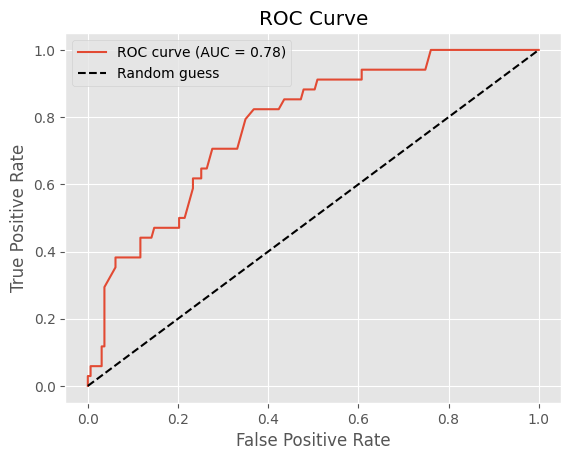

In [32]:
ecm = ECM(verbose=False, n_rules=8, use_gradient=True)
run_test(ecm, "Ender Classifier Modified with Gradient", X_train, y_train, X_test, y_test)

In [31]:
results = []

for n in range(1, 50):
    ecm = ECM(verbose=False, n_rules=n, use_gradient=True)
    acc, roc, f1 = run_small_test(ecm, f"ECM True (n_rules={n})", X_train, y_train, X_val, y_val, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
3 rules, ACC: 0.8636, ROC: 0.7469, F1: 0.5263
Best ROC AUC:
13 rules, ACC: 0.8333, ROC: 0.7994, F1: 0.4762
Best F1 Score:
8 rules, ACC: 0.8485, ROC: 0.7886, F1: 0.5833


Default rule creation time: 0.00168 seconds
Default rule: [ 0.6291357 -0.6291357]
####################################################################################
Rule: 1
Default Rule: MSE = 0.14658448912554006
	pain_level in [-1e+308, 1.25]
	defecation_pain_during in [-1e+308, 0.5]
	hormonal_birthcontrol in [-0.5, 1e+308]
	chronic_pain_level in [-1e+308, 8.0]
	height in [-1e+308, 179.0]
	alcohol_units in [-1e+308, 9.8]
=> vote for class 0 with weight 0.5473422814280682
[np.float64(0.5473422814280682), np.float64(-0.5473422814280682)]

Rule 1 creation time: 0.01380 seconds, total: 0.01381 seconds
####################################################################################
Rule: 2
Default Rule: MSE = 0.14658448912554006
Rule 0: MSE = 0.18149604237917094
	sex_pain_level in [3.5, 1e+308]
	menstruation_pain in [5.5, 1e+308]
	age in [25.0, 51.5]
	toparm_pain_apart in [-1e+308, 0.5]
	weight in [47.0, 108.5]
	smoking_time in [-1e+308, 16.0]
	first_menstruation in [9.5, 1e+308]
	ab

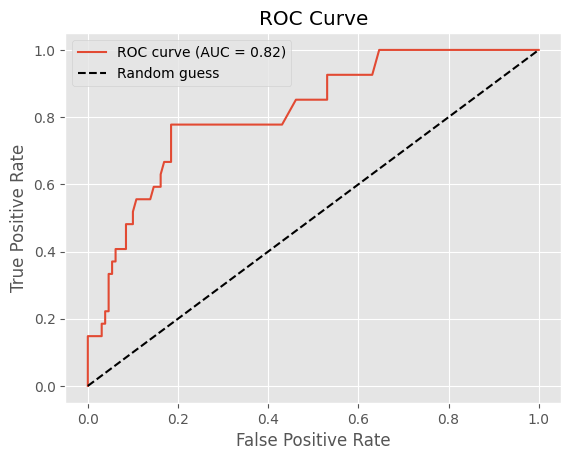

In [7]:
from EnderClassifierBoundedFast import EnderClassifier as ECBF

ecbf = ECBF(verbose=True, n_rules=16, use_gradient=False)
run_test(ecbf, "Ender Classifier Bounded Fast", X_train, y_train, X_test, y_test)

In [60]:
results = []

for n in range(1, 40):
    ecm = ECBF(verbose=False, n_rules=n, use_gradient=False)
    acc, roc, f1 = run_small_test(ecm, f"EBF False (n_rules={n})", X_train, y_train, X_val, y_val, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
15 rules, ACC: 0.8396, ROC: 0.7928, F1: 0.4848
Best ROC AUC:
16 rules, ACC: 0.8302, ROC: 0.8019, F1: 0.4706
Best F1 Score:
23 rules, ACC: 0.8396, ROC: 0.7913, F1: 0.5143


Ender Classifier Bounded Fast Gradient
Accuracy: 0.8289
ROC AUC: 0.7695
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       217
           1       0.52      0.33      0.40        46

    accuracy                           0.83       263
   macro avg       0.69      0.63      0.65       263
weighted avg       0.81      0.83      0.81       263

Confusion Matrix:
                    Class 0             Class 1             
Class 0             203                 14                    # True Negative (TN), False Positive (FP)
Class 1             31                  15                    # False Negative (FN), True Positive (TP)


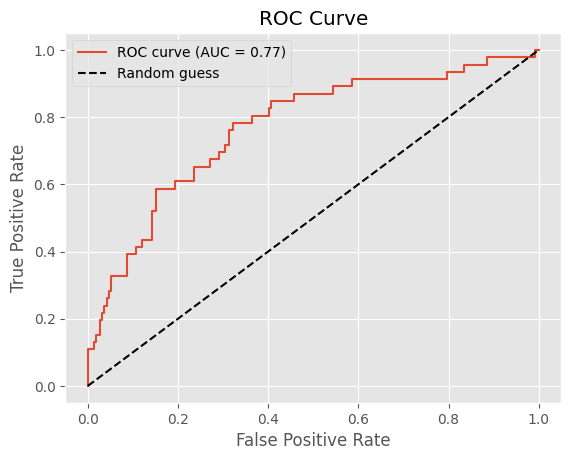

In [40]:
ecbf = ECBF(verbose=False, n_rules=46, use_gradient=True)
run_test(ecbf, "Ender Classifier Bounded Fast Gradient", X_train, y_train, X_test, y_test)

In [38]:
results = []

for n in range(17, 50):
    ecm = ECBF(verbose=False, n_rules=n, use_gradient=True)
    acc, roc, f1 = run_small_test(ecm, f"EBF True (n_rules={n})", X_train, y_train, X_test, y_test, verbose=False)
    results.append((n, acc, roc, f1))
    
accs = sorted(results, key=lambda x: x[1], reverse=True)
rocs = sorted(results, key=lambda x: x[2], reverse=True)
f1s = sorted(results, key=lambda x: x[3], reverse=True)

print("Best Accuracy:")
print(f"{accs[0][0]} rules, ACC: {accs[0][1]:.4f}, ROC: {accs[0][2]:.4f}, F1: {accs[0][3]:.4f}")
print("Best ROC AUC:")
print(f"{rocs[0][0]} rules, ACC: {rocs[0][1]:.4f}, ROC: {rocs[0][2]:.4f}, F1: {rocs[0][3]:.4f}")
print("Best F1 Score:")
print(f"{f1s[0][0]} rules, ACC: {f1s[0][1]:.4f}, ROC: {f1s[0][2]:.4f}, F1: {f1s[0][3]:.4f}")

Best Accuracy:
17 rules, ACC: 0.8441, ROC: 0.7450, F1: 0.4384
Best ROC AUC:
46 rules, ACC: 0.8289, ROC: 0.7695, F1: 0.4000
Best F1 Score:
17 rules, ACC: 0.8441, ROC: 0.7450, F1: 0.4384


### Compare rule lengths between the normal and bounded versions

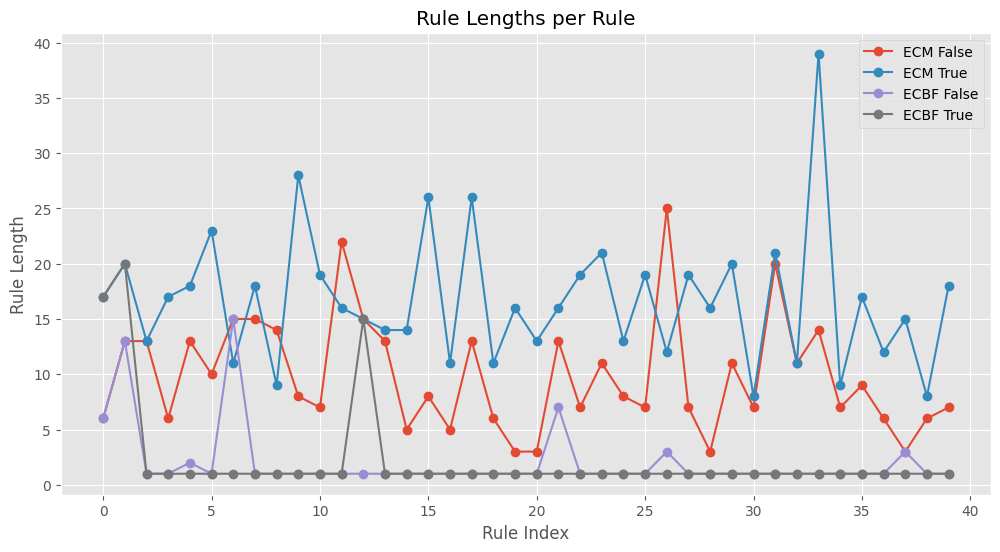

In [14]:
ecm = ECM(verbose=False, n_rules=40, use_gradient=False)
ecm.fit(X_train, y_train)
ecm_false_rule_lengths = [len(rule.conditions) for rule in ecm.rules]

ecm_true = ECM(verbose=False, n_rules=40, use_gradient=True)
ecm_true.fit(X_train, y_train)
ecm_true_rule_lengths = [len(rule.conditions) for rule in ecm_true.rules]

ecbf = ECBF(verbose=False, n_rules=40, use_gradient=False)
ecbf.fit(X_train, y_train)
ecbf_false_rule_lengths = [len(rule.conditions) for rule in ecbf.rules]

ecbf_true = ECBF(verbose=False, n_rules=40, use_gradient=True)
ecbf_true.fit(X_train, y_train)
ecbf_true_rule_lengths = [len(rule.conditions) for rule in ecbf_true.rules]

# plot the lengths per rule (x axis is the rule index, y is the length)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(ecm_false_rule_lengths)), ecm_false_rule_lengths, label='ECM False', marker='o')
plt.plot(range(len(ecm_true_rule_lengths)), ecm_true_rule_lengths, label='ECM True', marker='o')
plt.plot(range(len(ecbf_false_rule_lengths)), ecbf_false_rule_lengths, label='ECBF False', marker='o')
plt.plot(range(len(ecbf_true_rule_lengths)), ecbf_true_rule_lengths, label='ECBF True', marker='o')
plt.title('Rule Lengths per Rule')
plt.xlabel('Rule Index')
plt.ylabel('Rule Length')
plt.legend()
plt.show()

### Misc

In [37]:
from EnderClassifierBoundedFast import EnderClassifier

print("ENDER CLASSIFIER BOUNDED FAST")
ender = EnderClassifier(verbose=True, n_rules=14, use_gradient=False)
ender.fit(X_train, y_train)

ENDER CLASSIFIER BOUNDED FAST
Default rule: [ 0.49790622 -0.49790622]
####################################################################################
Rule: 1
Default Rule: MSE = 0.18340558976477644
Squared errors calculated in 0.0000 seconds
	sex_pain in [-1e+308, 1.5]
	defecation_pain_during in [-1e+308, 1.5]
	chronic_pain_level in [-1e+308, 3.5]
	family_endo in [-1e+308, 0.5]
	menstruation_lenght in [-1e+308, 27.0]
	stomach_ache_apart in [0.5, 1e+308]
	abdominal_pressure_apart in [0.5, 1e+308]
	cycle in [-1e+308, 45.0]
=> vote for class 0 with weight 0.5681012197701224
[np.float64(0.5681012197701224), np.float64(-0.5681012197701224)]

####################################################################################
Rule: 2
Default Rule: MSE = 0.18340558976477644
Rule 0: MSE = 0.17522474124544135
Squared errors calculated in 0.0000 seconds
	sex_pain_level in [3.5, 1e+308]
	chronic_pain_level in [0.5, 1e+308]
	menstruation_pain in [5.5, 1e+308]
	age in [23.5, 1e+308]
	smoking_t

Bounded Ender Classifier
Accuracy: 0.8384
ROC AUC: 0.8413
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       150
           1       0.75      0.50      0.60        48

    accuracy                           0.84       198
   macro avg       0.80      0.72      0.75       198
weighted avg       0.83      0.84      0.83       198

Confusion Matrix:
                    No Endometriosis    Endometriosis       
No Endometriosis    142                 8                     # True Negative (TN), False Positive (FP)
Endometriosis       24                  24                    # False Negative (FN), True Positive (TP)


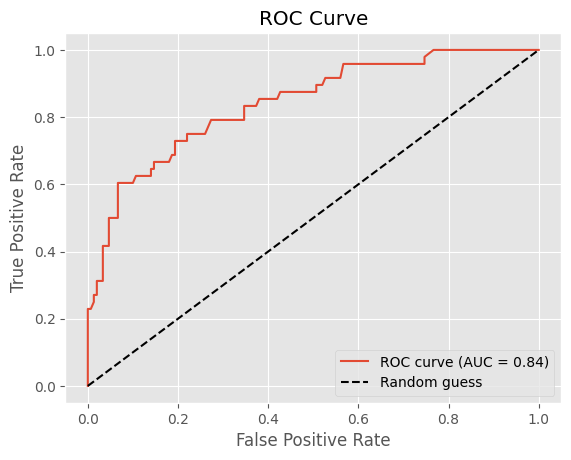

In [38]:
y_train_pred = ender.predict(X_train)
y_test_pred = ender.predict(X_test)

train_metrics = calculate_all_metrics(y_train, y_train_pred)
test_metrics = calculate_all_metrics(y_test, y_test_pred)

y_pred = np.array([np.argmax(pred) for pred in y_test_pred])

print("Bounded Ender Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
y_probs = ender.predict_proba(X_test)
print(f"ROC AUC: {roc_auc_score(y_test, y_probs[:, 1]):.4f}")
print("Classification Report - Test:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['No Endometriosis', 'Endometriosis']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
auc = roc_auc_score(y_test, y_probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [20]:
from EnderClassifierModified import EnderClassifier

print("EnderClassifierModified")
ender = EnderClassifier(verbose=True, n_rules=16, use_gradient=False)
ender.fit(X_train, y_train)

EnderClassifierModified
Default rule: [np.float64(0.4979062213548282), np.float64(-0.4979062213548282)]
####################################################################################
Rule: 1
	sex_pain in [-1e+308, 1.5]
	defecation_pain_during in [-1e+308, 1.5]
	chronic_pain_level in [-1e+308, 3.5]
	family_endo in [-1e+308, 0.5]
	menstruation_lenght in [-1e+308, 27.0]
	stomach_ache_apart in [0.5, 1e+308]
	abdominal_pressure_apart in [0.5, 1e+308]
	cycle in [-1e+308, 45.0]
=> vote for class 0 with weight 0.5681012197701224
[np.float64(0.5681012197701224), np.float64(-0.5681012197701224)]

####################################################################################
Rule: 2
	sex_pain_level in [3.5, 1e+308]
	chronic_pain_level in [0.5, 1e+308]
	menstruation_pain in [5.5, 1e+308]
	age in [23.5, 1e+308]
	smoking_time in [-1e+308, 23.5]
	height in [157.0, 1e+308]
	weight in [-1e+308, 114.5]
	first_menstruation in [6.5, 1e+308]
	alcohol_units in [-1e+308, 8.05]
=> vote for class 1

Bounded Ender Classifier
Accuracy: 0.8232
ROC AUC: 0.8058
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       150
           1       0.68      0.52      0.59        48

    accuracy                           0.82       198
   macro avg       0.77      0.72      0.74       198
weighted avg       0.81      0.82      0.81       198

Confusion Matrix:
                    No Endometriosis    Endometriosis       
No Endometriosis    138                 12                    # True Negative (TN), False Positive (FP)
Endometriosis       23                  25                    # False Negative (FN), True Positive (TP)


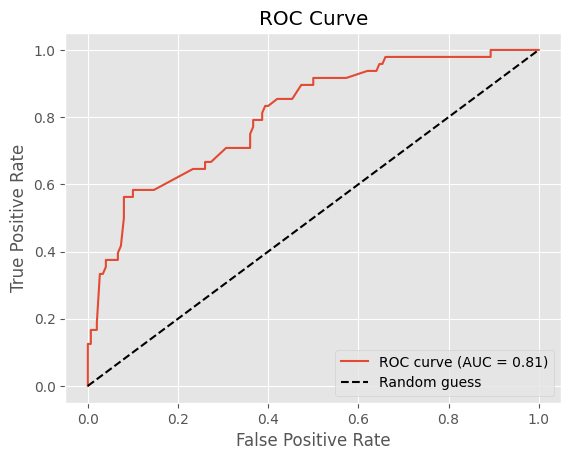

In [21]:
y_train_pred = ender.predict(X_train)
y_test_pred = ender.predict(X_test)

train_metrics = calculate_all_metrics(y_train, y_train_pred)
test_metrics = calculate_all_metrics(y_test, y_test_pred)

y_pred = np.array([np.argmax(pred) for pred in y_test_pred])

print("Bounded Ender Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
y_probs = ender.predict_proba(X_test)
print(f"ROC AUC: {roc_auc_score(y_test, y_probs[:, 1]):.4f}")
print("Classification Report - Test:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['No Endometriosis', 'Endometriosis']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
auc = roc_auc_score(y_test, y_probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

XGBoost Classifier
Accuracy: 0.8182
ROC AUC: 0.8283
Classification Report - Test:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       150
           1       0.65      0.54      0.59        48

    accuracy                           0.82       198
   macro avg       0.76      0.72      0.74       198
weighted avg       0.81      0.82      0.81       198

Confusion Matrix:
                    No Endometriosis    Endometriosis       
No Endometriosis    136                 14                    # True Negative (TN), False Positive (FP)
Endometriosis       22                  26                    # False Negative (FN), True Positive (TP)


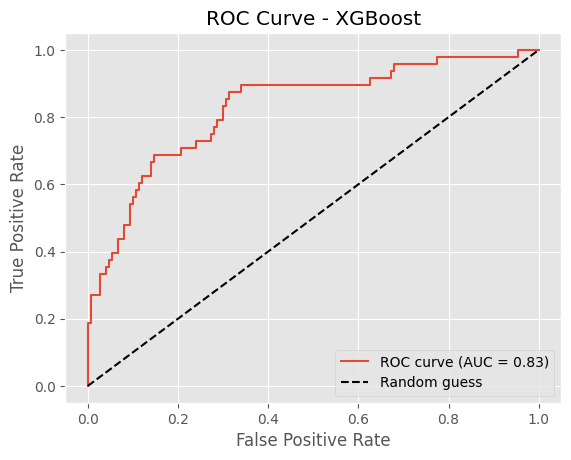

In [34]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

train_metrics_xgb = calculate_all_metrics(y_train, y_train_pred_xgb)
test_metrics_xgb = calculate_all_metrics(y_test, y_test_pred_xgb)

print("XGBoost Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.4f}")
y_probs_xgb = xgb_model.predict_proba(X_test)
print(f"ROC AUC: {roc_auc_score(y_test, y_probs_xgb[:, 1]):.4f}")
print("Classification Report - Test:")
print(classification_report(y_test, y_test_pred_xgb))
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm_xgb[0, 0]:<20}{cm_xgb[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm_xgb[1, 0]:<20}{cm_xgb[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb[:, 1])
auc_xgb = roc_auc_score(y_test, y_probs_xgb[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f"ROC curve (AUC = {auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [66]:
# ENDER = ECBF
ENDER = ECM

# for n in [3,5,7,9,12,15,18,20]:
for n in range(7,15):
    print(f"Testing with n_rules={n}")
    ender = ENDER(verbose=False, n_rules=n, use_gradient=True)
    ender.fit(X_train, y_train)
    y_pred = ender.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_probs = ender.predict_proba(X_test)
    print(f"n_rules={n}, Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"n_rules={n}, ROC AUC: {roc_auc_score(y_test, y_probs[:, 1]):.4f}")
    print("================================")

Testing with n_rules=7
n_rules=7, Accuracy: 0.7879
n_rules=7, ROC AUC: 0.7809
Testing with n_rules=8
n_rules=8, Accuracy: 0.7879
n_rules=8, ROC AUC: 0.7883
Testing with n_rules=9
n_rules=9, Accuracy: 0.8030
n_rules=9, ROC AUC: 0.7919
Testing with n_rules=10
n_rules=10, Accuracy: 0.7980
n_rules=10, ROC AUC: 0.7844
Testing with n_rules=11
n_rules=11, Accuracy: 0.7980
n_rules=11, ROC AUC: 0.7957
Testing with n_rules=12
n_rules=12, Accuracy: 0.7929
n_rules=12, ROC AUC: 0.7817
Testing with n_rules=13
n_rules=13, Accuracy: 0.7980
n_rules=13, ROC AUC: 0.7812
Testing with n_rules=14
n_rules=14, Accuracy: 0.7828
n_rules=14, ROC AUC: 0.7803
